In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import optuna
from optuna import Trial
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from xgboost import plot_tree as xgplt
from lightgbm import plot_tree as lgplt
from matplotlib.pylab import rcParams
from xgboost import plot_importance


import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [2]:
df = pd.read_csv('C:\\Users\\saint\\OneDrive\\바탕 화면\\k6.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211682 entries, 0 to 211681
Data columns (total 36 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            211682 non-null  int64  
 1   Descr                 211682 non-null  object 
 2   K6 KILN SPEED 1       211682 non-null  float64
 3   L6 #2 PAN CONVEYOR    211682 non-null  float64
 4   K6 TEMP. INLET        211682 non-null  float64
 5   K6 MAIN MOTOR         211682 non-null  float64
 6   K6 AUX. COAL FD T/H   211682 non-null  float64
 7   K6 MAIN COAL FEED     211682 non-null  float64
 8   K6 RDF CFW FEED       211682 non-null  float64
 9   K6 MEAL TOTAL T/H     211682 non-null  float64
 10  K6 KHD 3CH DAMPER     211682 non-null  float64
 11  K6 KHD 4CH DAMPER     211682 non-null  float64
 12  K6 POS.THROTLE FLAP   211682 non-null  float64
 13  K6 TEMP.GAS PIPE3     211682 non-null  float64
 14  K6 TEMP.GAS PIPE2 E   211682 non-null  float64
 15  

In [4]:
df = df.drop(['Unnamed: 0','Descr'],axis=1)

In [5]:
len(df)*0.8

169345.6

In [6]:
train = df.iloc[:127009]
val = df.iloc[127009:169345]
test = df.iloc[169345:]

In [7]:
train_x = train.drop(['K6 TEMP.MAT.INLET E','K6 TEMP.MAT.INLET W'], axis=1)
train_y = (train['K6 TEMP.MAT.INLET E']+train['K6 TEMP.MAT.INLET W'])/2

In [8]:
val_x = val.drop(['K6 TEMP.MAT.INLET E','K6 TEMP.MAT.INLET W'], axis=1)
val_y = (val['K6 TEMP.MAT.INLET E']+val['K6 TEMP.MAT.INLET W'])/2

In [9]:
test_x = test.drop(['K6 TEMP.MAT.INLET E','K6 TEMP.MAT.INLET W'], axis=1)
test_y = (test['K6 TEMP.MAT.INLET E']+test['K6 TEMP.MAT.INLET W'])/2

In [10]:
test_y = np.array(test_y)

In [11]:
sc = StandardScaler()
train_x_sc = sc.fit_transform(train_x)
test_x_sc = sc.transform(test_x)

In [12]:
ms = MinMaxScaler()
train_x_ms = ms.fit_transform(train_x)
test_x_ms = ms.transform(test_x)

In [13]:
rcParams['figure.figsize'] = 150, 500


# 1. xgb

In [17]:
def xgb_objective(trial):
    params = {'tree_method': 'gpu_hist',
              'max_depth':trial.suggest_int('max_depth',3,6),
        
             }
    model = xgb.XGBRegressor(**params)
    model.fit(train_x,train_y,eval_set=[(test_x, test_y)],verbose=False)
    pred = model.predict(test_x)
    mse = mean_squared_error(pred,test_y)
    return mse

In [18]:
xgb_study = optuna.create_study(direction='minimize')
xgb_study.optimize(xgb_objective, n_trials=5)

[I 2023-02-22 14:37:17,961] A new study created in memory with name: no-name-8ce47223-f62d-48e6-975c-50248670bac7
[I 2023-02-22 14:37:18,986] Trial 0 finished with value: 1310.8687367801012 and parameters: {'max_depth': 3}. Best is trial 0 with value: 1310.8687367801012.
[I 2023-02-22 14:37:19,649] Trial 1 finished with value: 2344.839153095928 and parameters: {'max_depth': 5}. Best is trial 0 with value: 1310.8687367801012.
[I 2023-02-22 14:37:20,244] Trial 2 finished with value: 1975.4723178330348 and parameters: {'max_depth': 4}. Best is trial 0 with value: 1310.8687367801012.
[I 2023-02-22 14:37:20,901] Trial 3 finished with value: 2344.839153095928 and parameters: {'max_depth': 5}. Best is trial 0 with value: 1310.8687367801012.
[I 2023-02-22 14:37:21,557] Trial 4 finished with value: 2344.839153095928 and parameters: {'max_depth': 5}. Best is trial 0 with value: 1310.8687367801012.


In [64]:
print(xgb_study.best_value)

print(xgb_study.best_trial.params)

2576.564198243535
{'max_depth': 5}


In [22]:
# no scaling
xgb_model = xgb.XGBRegressor(max_depth= 3)
model = xgb_model.fit(train_x,train_y)

In [62]:
train_pred_xgb = xgb_model.predict(train_x)
test_pred_xgb = xgb_model.predict(test_x)

In [63]:
# MSE
print(mean_squared_error(train_pred_xgb,train_y))
print(mean_squared_error(test_pred_xgb,test_y))

217.99401470755177
758.76982349574


In [217]:
# sc
xgb_model = xgb.XGBRegressor()
xgb_model.fit(train_x_sc,train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [218]:
train_pred_xgb = xgb_model.predict(train_x_sc)
test_pred_xgb = xgb_model.predict(test_x_sc)

In [219]:
# MSE
print(mean_squared_error(train_pred_xgb,train_y))
print(mean_squared_error(test_pred_xgb,test_y))

60.9903033182677
1018.2479690310631


In [220]:
# ms
xgb_model = xgb.XGBRegressor()
xgb_model.fit(train_x_ms,train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [221]:
train_pred_xgb = xgb_model.predict(train_x_ms)
test_pred_xgb = xgb_model.predict(test_x_ms)

In [222]:
# MSE
print(mean_squared_error(train_pred_xgb,train_y))
print(mean_squared_error(test_pred_xgb,test_y))

60.99037469338892
1018.260471984273


In [49]:
# 변수 중요도
a = xgb_model.feature_importances_
a = np.round(a*100/sum(a),2)
print(a)
print(np.argmax(a))

[ 3.09  1.55  3.44  0.58  5.39  1.76  2.56  3.71  0.68  2.48  4.45  2.6
  1.29  9.86 17.12  3.53  1.11  0.36  1.69  1.8   0.3   2.26  2.54  1.
  0.72  3.92  7.34  2.19  2.33  3.93  1.79  2.63]
14


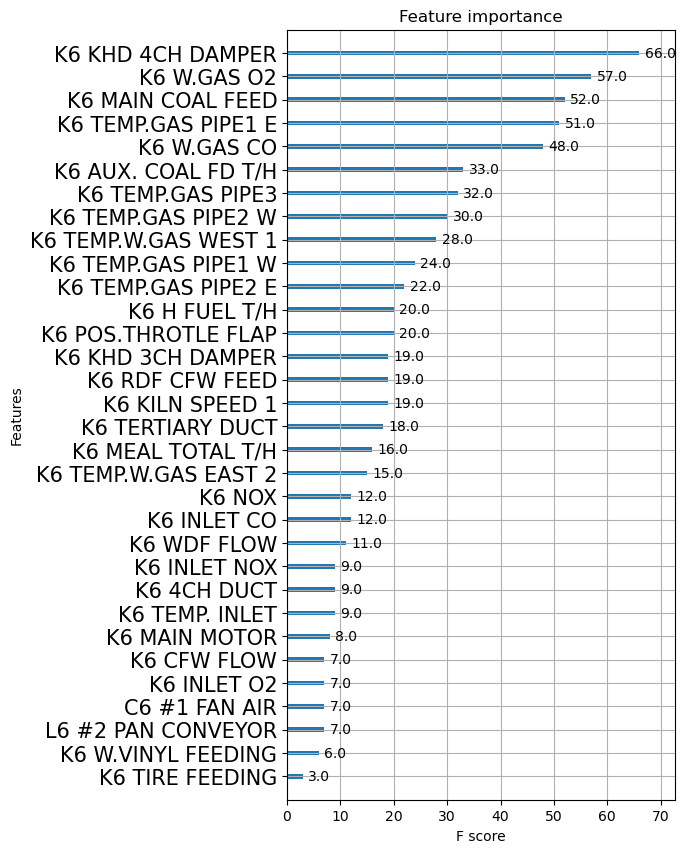

In [62]:
rcParams['figure.figsize'] = 5, 10
plot_importance(xgb_model)
plt.yticks(fontsize=15)
plt.show()

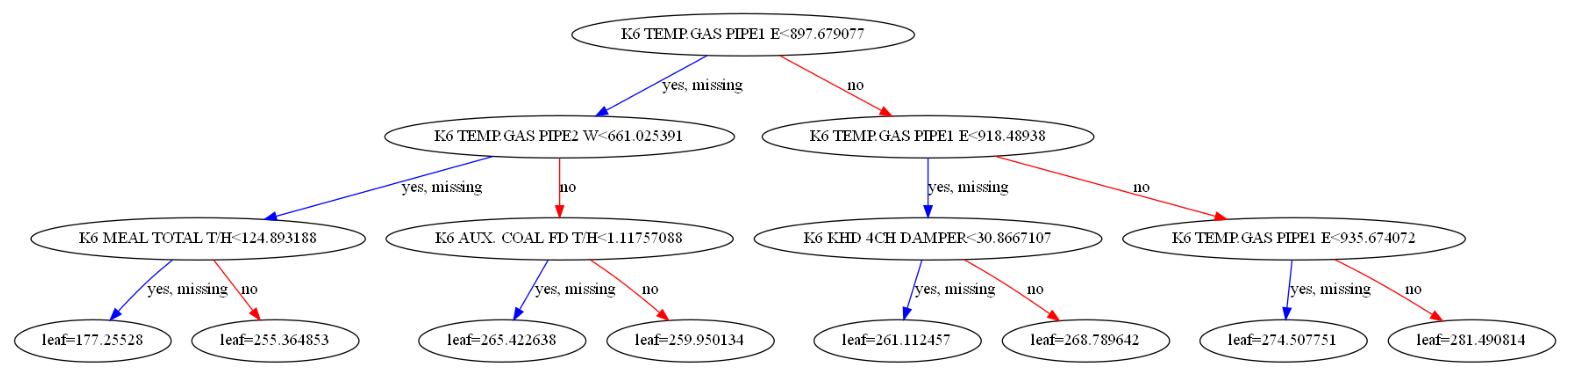

In [86]:
rcParams['figure.figsize'] = 20,40
xgplt(xgb_model)
plt.show()

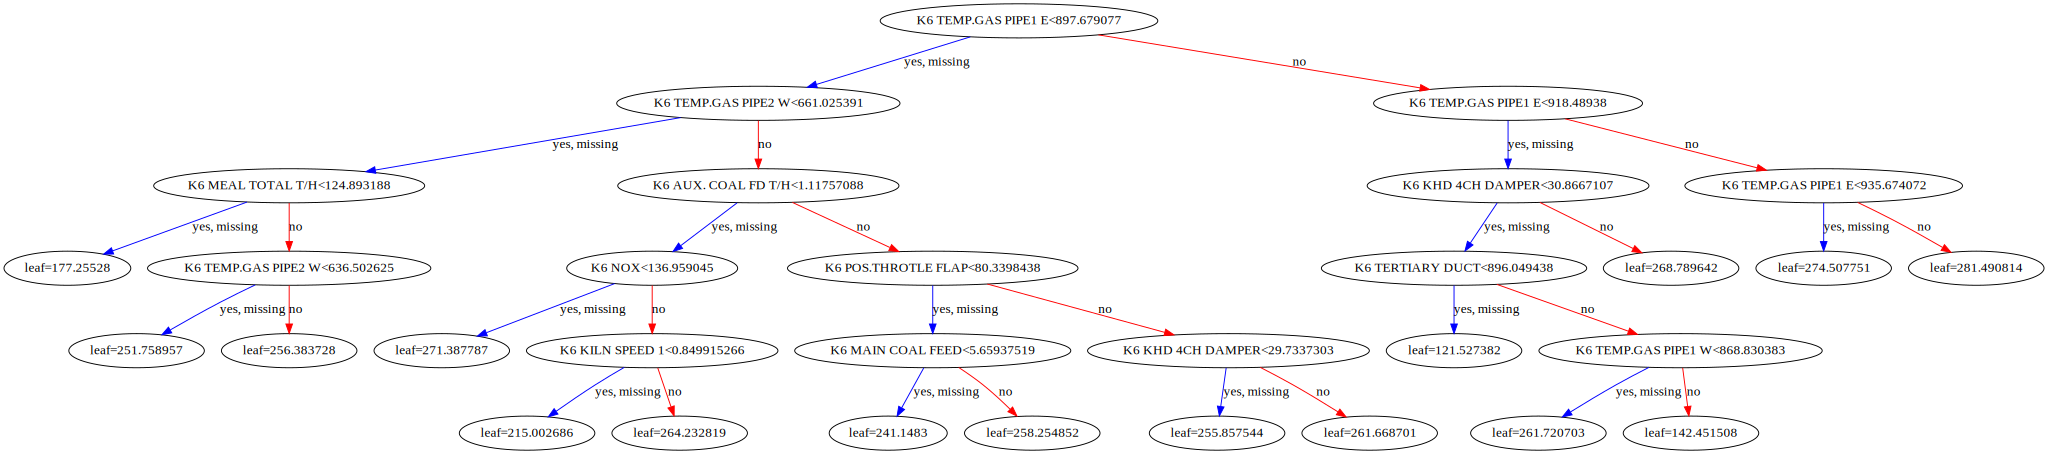

In [80]:
xgb.to_graphviz(xgb_model)

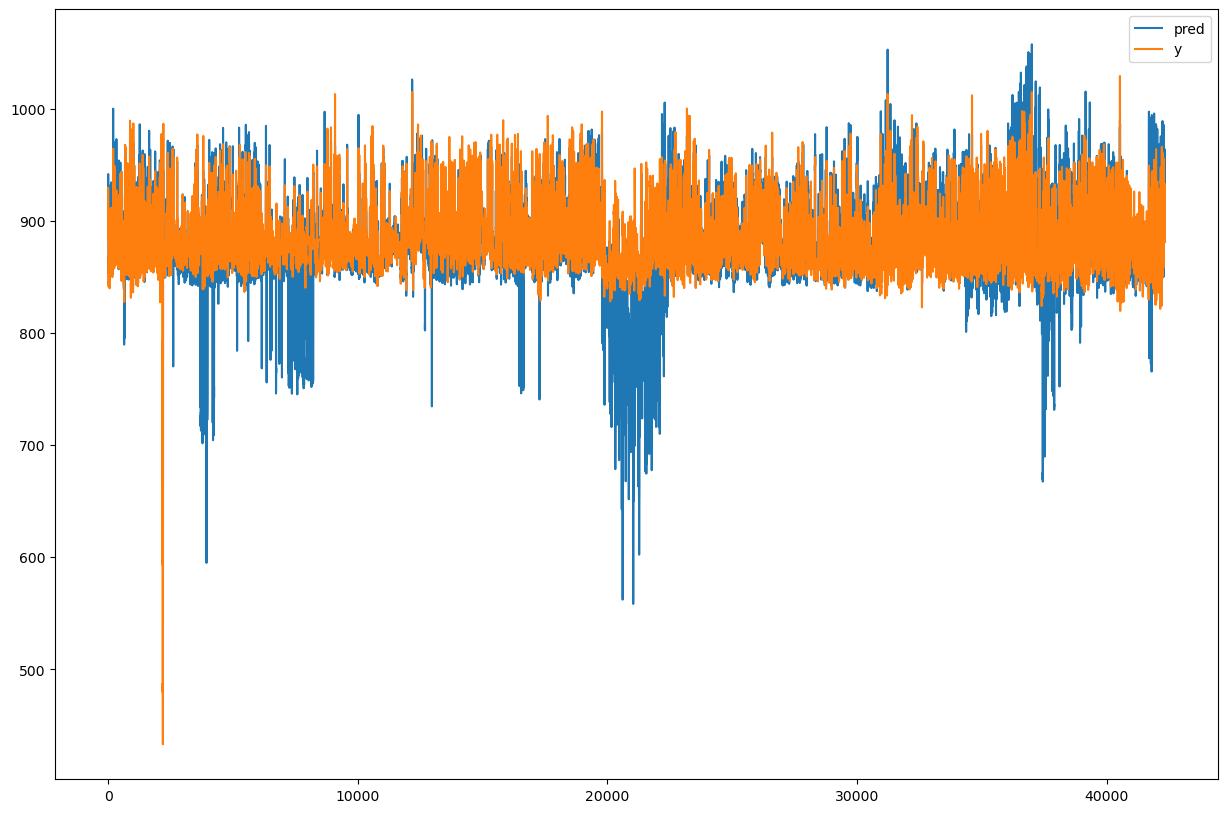

In [81]:
plt.figure(figsize=(15,10))
plt.plot(test_pred_xgb,label='pred')
plt.plot(test_y,label='y')
plt.legend()
plt.show()

# 2. lgb

In [39]:
# no scaling
lgb_model = lgb.LGBMRegressor(max_depth=3)
lgb_model.fit(train_x,train_y)

LGBMRegressor(max_depth=3)

In [40]:
train_pred_lgb = lgb_model.predict(train_x)
test_pred_lgb = lgb_model.predict(test_x)

In [41]:
# MSE
print(mean_squared_error(train_pred_lgb,train_y))
print(mean_squared_error(test_pred_lgb,test_y))

317.2952988966478
338.1409072635989


In [228]:
# sc
lgb_model = lgb.LGBMRegressor()
lgb_model.fit(train_x_sc,train_y)

LGBMRegressor()

In [229]:
train_pred_lgb = lgb_model.predict(train_x_sc)
test_pred_lgb = lgb_model.predict(test_x_sc)

In [230]:
# MSE
print(mean_squared_error(train_pred_lgb,train_y))
print(mean_squared_error(test_pred_lgb,test_y))

99.129477975129
482.37800676636766


In [231]:
# ms
lgb_model = lgb.LGBMRegressor()
lgb_model.fit(train_x_ms,train_y)

LGBMRegressor()

In [232]:
train_pred_lgb = lgb_model.predict(train_x_ms)
test_pred_lgb = lgb_model.predict(test_x_ms)

In [233]:
# MSE
print(mean_squared_error(train_pred_lgb,train_y))
print(mean_squared_error(test_pred_lgb,test_y))

97.17258454275068
526.0239641988532


In [140]:
# 변수 중요도
a = lgb_model.feature_importances_
a = np.round(a*100/sum(a),2)
print(a)
print(np.argmax(a))

[1.63 1.13 1.3  0.73 3.97 4.97 3.8  3.   2.03 8.03 2.47 4.6  3.7  3.97
 7.   4.83 2.8  1.6  4.53 3.2  1.63 0.5  0.63 1.67 0.87 1.7  1.83 8.
 6.9  1.47 1.87 3.63]
9


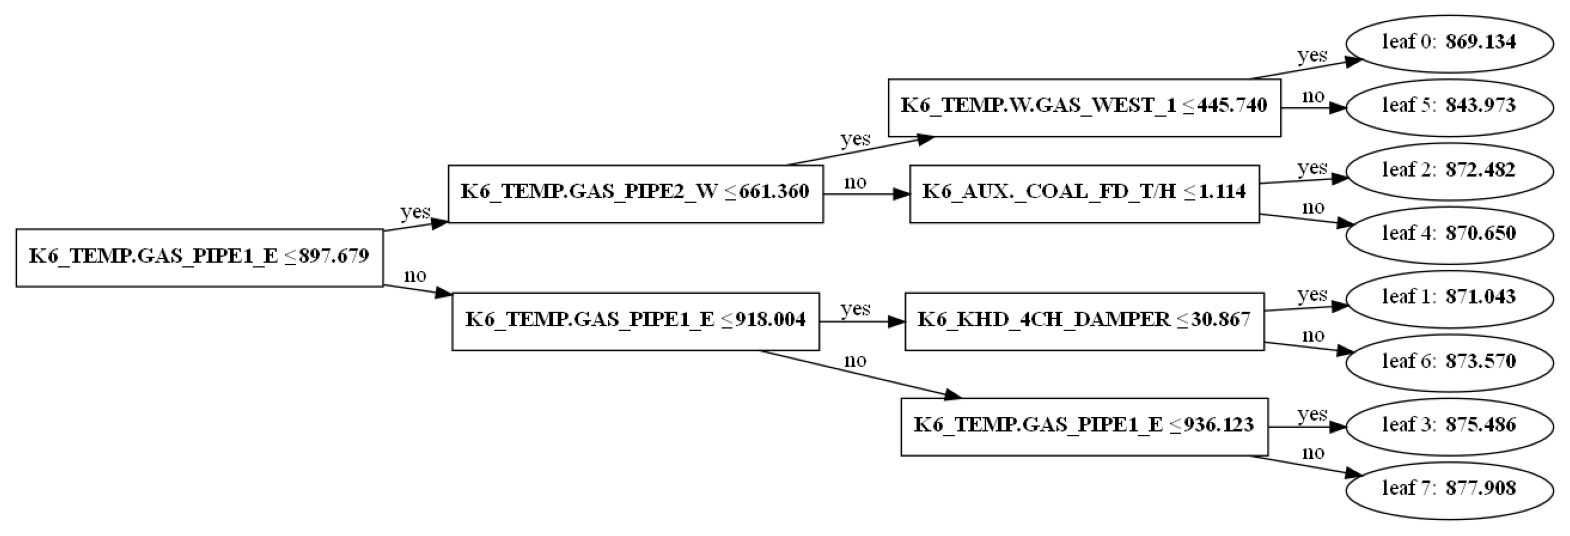

In [89]:
lgplt(lgb_model)
plt.show()

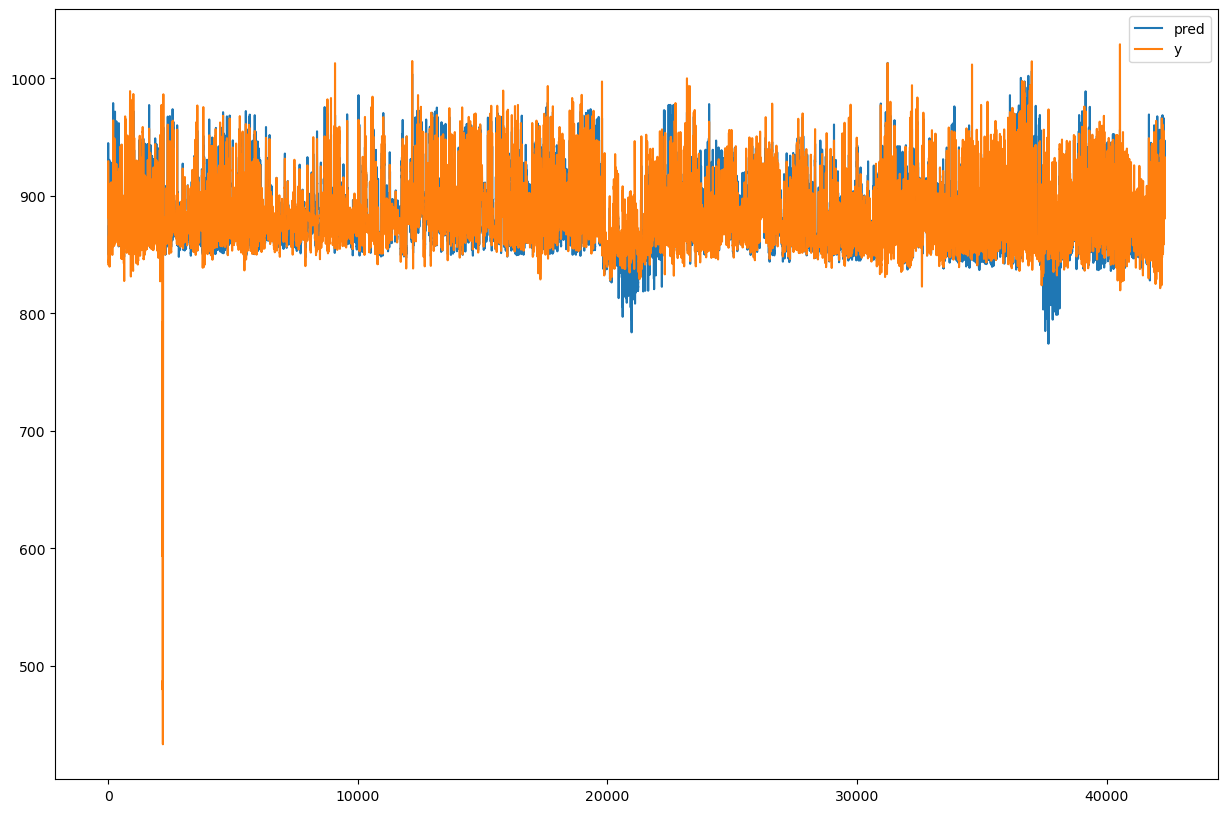

In [305]:
plt.figure(figsize=(15,10))
plt.plot(test_pred_lgb,label='pred')
plt.plot(test_y,label='y')
plt.legend()
plt.show()

# 3. linear_regression

In [19]:
# no scaling
lr_model = LinearRegression()
lr_model.fit(train_x,train_y)

LinearRegression()

In [20]:
train_pred_lr = lr_model.predict(train_x)
test_pred_lr = lr_model.predict(test_x)

In [21]:
# MSE
print(mean_squared_error(train_pred_lr,train_y))
print(mean_squared_error(test_pred_lr,test_y))

510.4565223126476
511.89553093576023


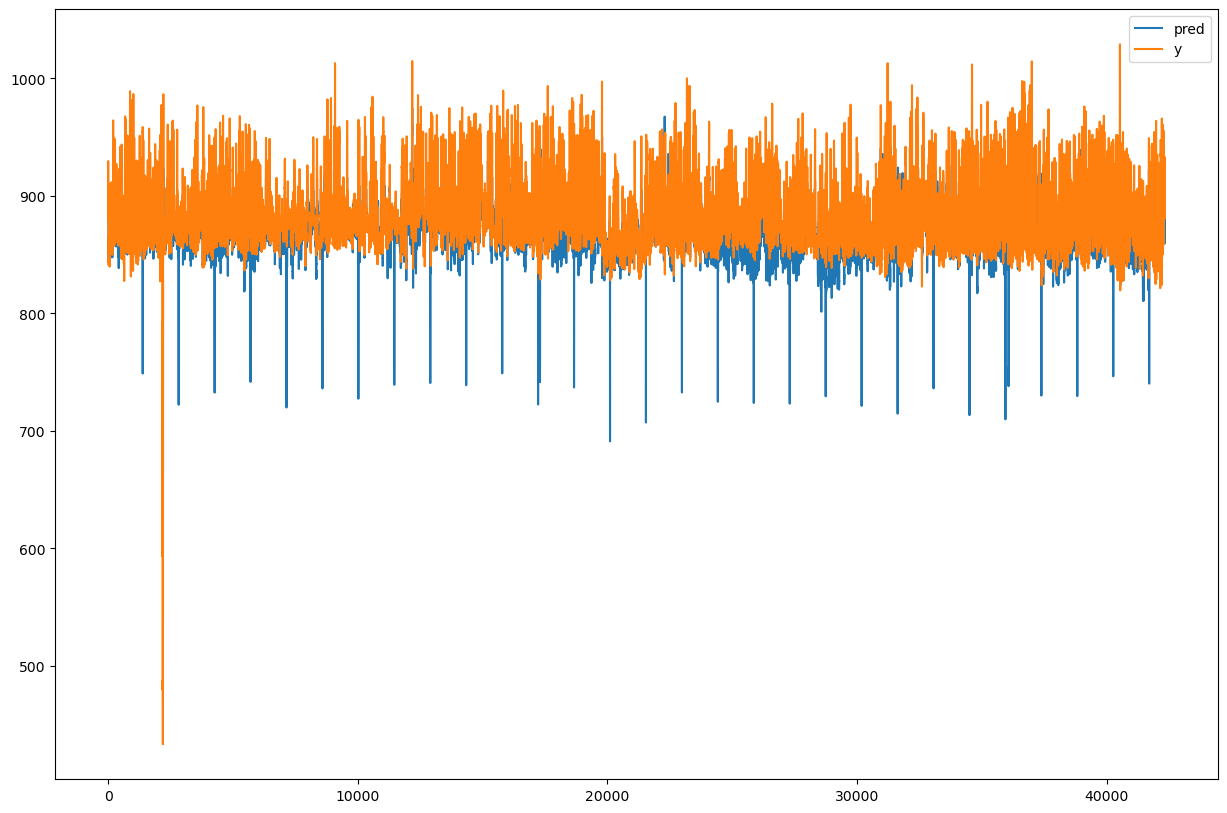

In [88]:
plt.figure(figsize=(15,10))
plt.plot(test_pred_lr,label='pred')
plt.plot(test_y,label='y')
plt.legend()
plt.show()

# 4. lasso

In [327]:
# no scaling
ls_model = Lasso(alpha=1)
ls_model.fit(train_x,train_y)

Lasso(alpha=1)

In [328]:
train_pred_ls = ls_model.predict(train_x)
test_pred_ls = ls_model.predict(test_x)

In [329]:
# MSE
print(mean_squared_error(train_pred_ls,train_y))
print(mean_squared_error(test_pred_ls,test_y))

551.8550582509455
496.47819486575605


In [25]:
# sc
ls_model = Lasso(alpha=1)
ls_model.fit(train_x_sc,train_y)

Lasso(alpha=1)

In [26]:
train_pred_ls = ls_model.predict(train_x_sc)
test_pred_ls = ls_model.predict(test_x_sc)

In [27]:
# MSE
print(mean_squared_error(train_pred_ls,train_y))
print(mean_squared_error(test_pred_ls,test_y))

556.8868997653594
434.36950818034734


In [118]:
# ms
ls_model = Lasso(alpha=1)
ls_model.fit(train_x_ms,train_y)

Lasso(alpha=1)

In [119]:
train_pred_ls = ls_model.predict(train_x_ms)
test_pred_ls = ls_model.predict(test_x_ms)

In [120]:
# MSE
print(mean_squared_error(train_pred_ls,train_y))
print(mean_squared_error(test_pred_ls,test_y))

870.3794340026092
979.3757894475382


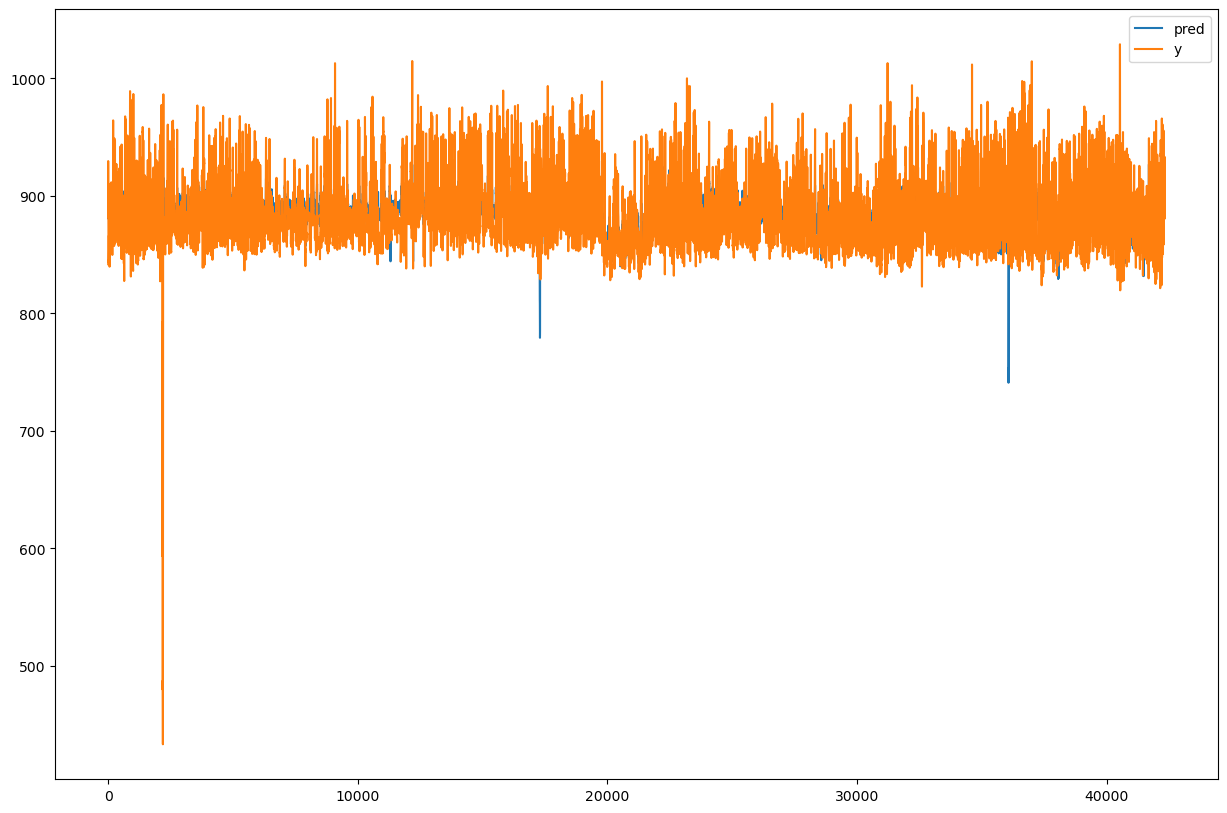

In [326]:
plt.figure(figsize=(15,10))
plt.plot(test_pred_ls,label='pred')
plt.plot(test_y,label='y')
plt.legend()
plt.show()

# 5. Ridge

In [28]:
rd_model = Ridge(alpha=10)
rd_model.fit(train_x,train_y)

Ridge(alpha=10)

In [29]:
train_pred_rd = rd_model.predict(train_x)
test_pred_rd = rd_model.predict(test_x)

In [30]:
# MSE
print(mean_squared_error(train_pred_rd,train_y))
print(mean_squared_error(test_pred_rd,test_y))

513.1113318048605
448.81479458765926


In [176]:
# sc
rd_model = Ridge(alpha=1)
rd_model.fit(train_x_sc,train_y)

Ridge(alpha=1)

In [177]:
train_pred_rd = rd_model.predict(train_x_sc)
test_pred_rd = rd_model.predict(test_x_sc)

In [178]:
# MSE
print(mean_squared_error(train_pred_rd,train_y))
print(mean_squared_error(test_pred_rd,test_y))

510.4565224218756
511.8857843409494


In [179]:
# ms
rd_model = Ridge(alpha=1)
rd_model.fit(train_x_ms,train_y)

Ridge(alpha=1)

In [180]:
train_pred_rd = rd_model.predict(train_x_ms)
test_pred_rd = rd_model.predict(test_x_ms)

In [181]:
# MSE
print(mean_squared_error(train_pred_rd,train_y))
print(mean_squared_error(test_pred_rd,test_y))

510.46685535535175
510.71393613323613


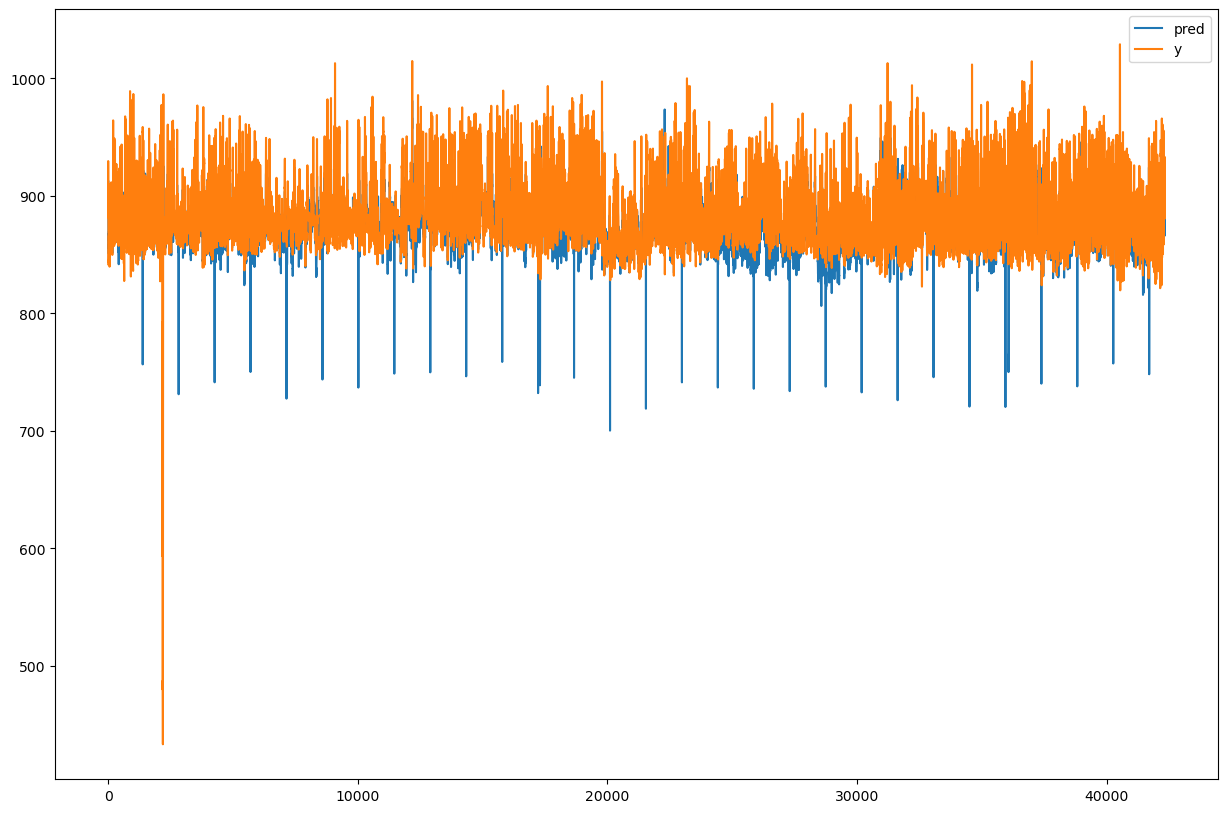

In [336]:
plt.figure(figsize=(15,10))
plt.plot(test_pred_rd,label='pred')
plt.plot(test_y,label='y')
plt.legend()
plt.show()

# 6. Ensemble

In [33]:
# MSE
train_pred = (train_pred_xgb + train_pred_lgb + train_pred_lr + train_pred_ls + train_pred_rd)/5
test_pred = (test_pred_xgb + test_pred_lgb + test_pred_lr + test_pred_ls + test_pred_rd)/5

print(mean_squared_error(train_pred,train_y))
print(mean_squared_error(test_pred,test_y))

366.8858679957198
346.64405134238143


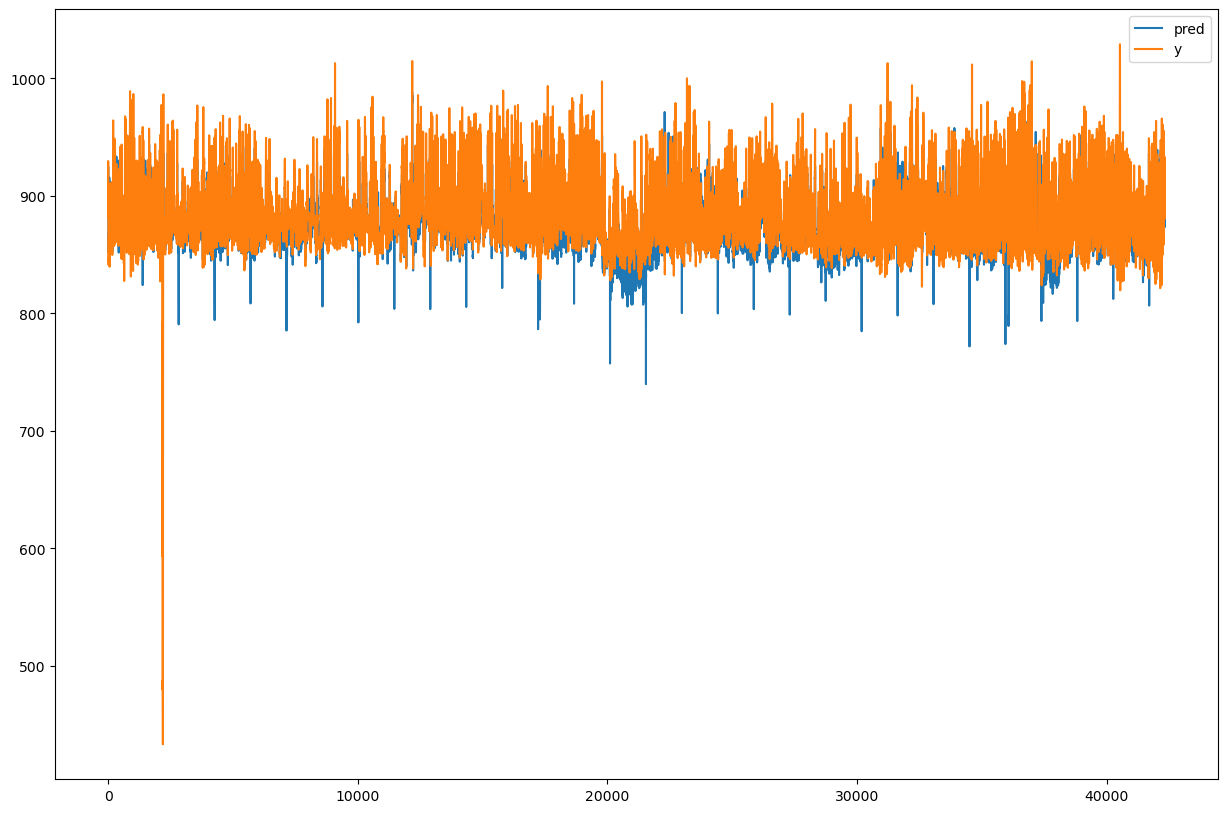

In [338]:
plt.figure(figsize=(15,10))
plt.plot(test_pred,label='pred')
plt.plot(test_y,label='y')
plt.legend()
plt.show()

In [339]:
len(test_pred)

42337

In [340]:
len(test_y)

42337

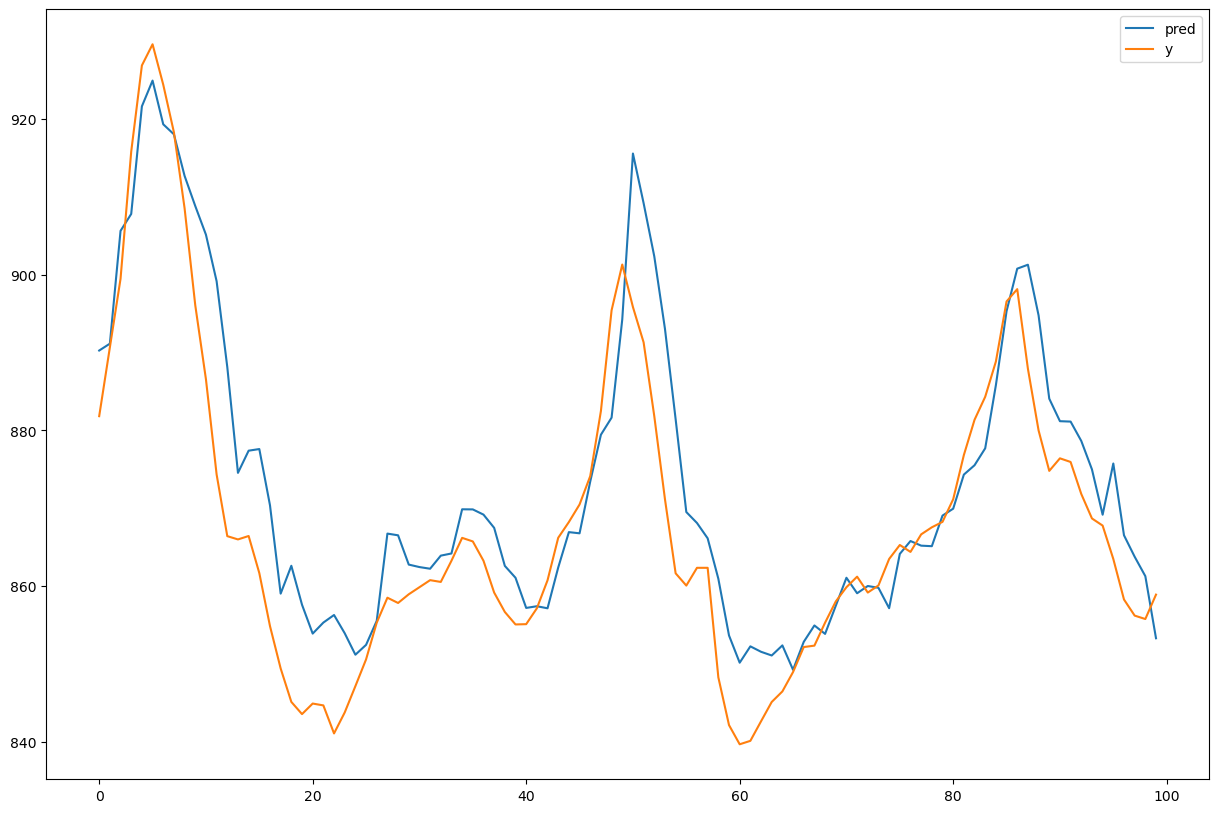

In [341]:
plt.figure(figsize=(15,10))
plt.plot(test_pred[:100],label='pred')
plt.plot(test_y[:100],label='y')
plt.legend()
plt.show()

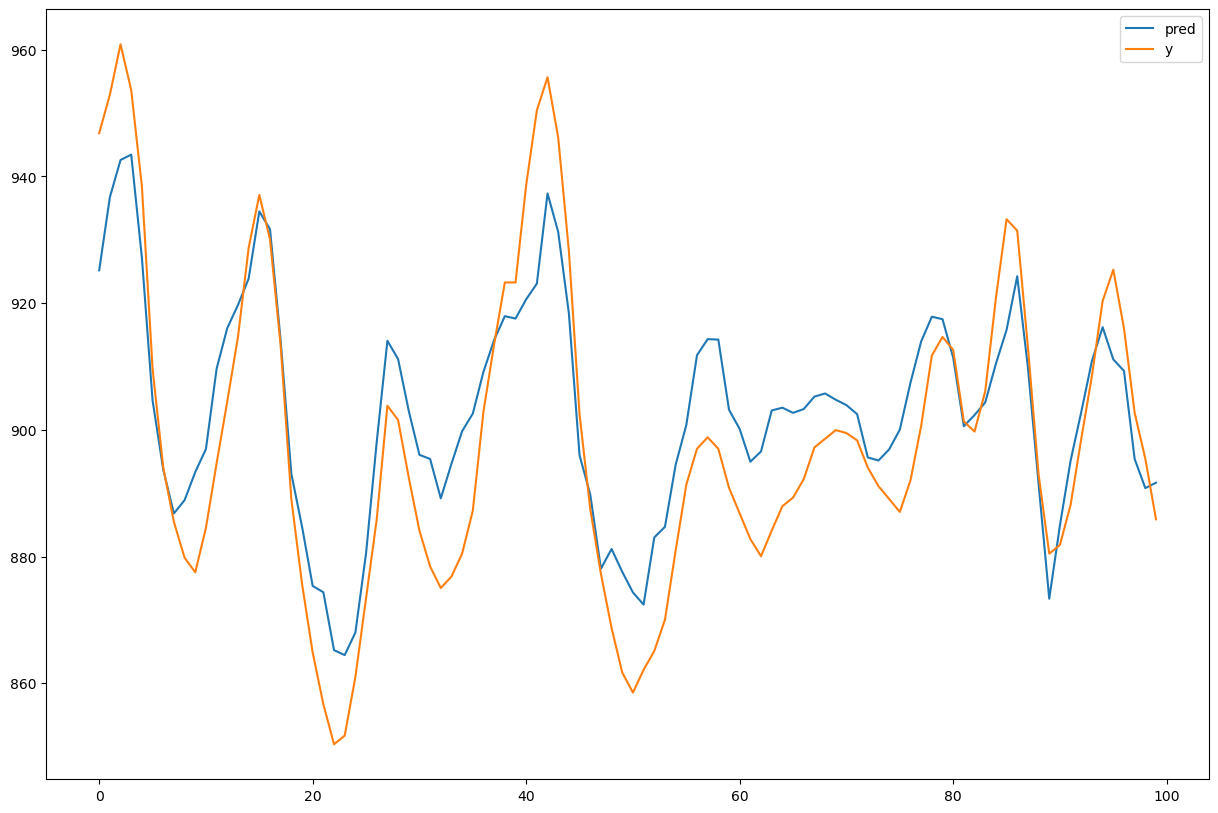

In [342]:
plt.figure(figsize=(15,10))
plt.plot(test_pred[42237:],label='pred')
plt.plot(test_y[42237:],label='y')
plt.legend()
plt.show()

# 모델 비교

In [59]:
# xgb 모델
def model_XGB(train_x, train_y, val_x, val_y,num_try):
    def objective(trial):
        params = {
                  'max_depth':trial.suggest_int('max_depth',3,6),
        
                 }
        model = xgb.XGBRegressor(**params)
        model.fit(train_x,train_y,eval_set=[(val_x, val_y)],verbose=False)
        
        pred = model.predict(val_x)
        mse = mean_squared_error(pred,val_y)
        return mse
    
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=num_try)
       
    return study.best_value  
    

In [60]:
model_XGB(train_x, train_y, val_x, val_y,5)

[I 2023-01-20 17:30:51,284] A new study created in memory with name: no-name-46c2a4db-b65d-4a98-be5e-23bcc5ddbc8a
[I 2023-01-20 17:30:52,564] Trial 0 finished with value: 2458.4262036135524 and parameters: {'max_depth': 5}. Best is trial 0 with value: 2458.4262036135524.
[I 2023-01-20 17:30:54,109] Trial 1 finished with value: 1517.2145732794436 and parameters: {'max_depth': 6}. Best is trial 1 with value: 1517.2145732794436.
[I 2023-01-20 17:30:55,363] Trial 2 finished with value: 2458.4262036135524 and parameters: {'max_depth': 5}. Best is trial 1 with value: 1517.2145732794436.
[I 2023-01-20 17:30:56,169] Trial 3 finished with value: 1948.761980920463 and parameters: {'max_depth': 3}. Best is trial 1 with value: 1517.2145732794436.
[I 2023-01-20 17:30:57,177] Trial 4 finished with value: 3164.0706609569306 and parameters: {'max_depth': 4}. Best is trial 1 with value: 1517.2145732794436.


1517.2145732794436

In [59]:
def model_LGB(train_x, train_y, val_x, val_y,num_try):
    def objective(trial):
        params = {
                  'max_depth':trial.suggest_int('max_depth',3,6),
        
                 }
        model = lgb.LGBMRegressor(**params)
        model.fit(train_x,train_y,eval_set=[(val_x, val_y)],verbose=False)
        
        pred = model.predict(val_x)
        mse = mean_squared_error(pred,val_y)
        return mse
    
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=num_try)
       
    return study.best_value  

In [60]:
def model_LR(train_x, train_y, val_x, val_y):
    model = LinearRegression()
    model.fit(train_x,train_y)
        
    pred = model.predict(val_x)
    mse = mean_squared_error(pred,val_y)
    return mse      

In [69]:
def model_Lasso(train_x, train_y, val_x, val_y,num_try):
    def objective(trial):
        params = {
                  'alpha':trial.suggest_float('alpha',0.001,10),
        
                 }
        model = Lasso(**params)
        model.fit(train_x,train_y)
        
        pred = model.predict(val_x)
        mse = mean_squared_error(pred,val_y)
        return mse
    
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=num_try)
       
    return study.best_value 

In [71]:
def model_Ridge(train_x, train_y, val_x, val_y,num_try):
    def objective(trial):
        params = {
                  'alpha':trial.suggest_float('alpha',0.001,10),
        
                 }
        model = Ridge(**params)
        model.fit(train_x,train_y)
        
        pred = model.predict(val_x)
        mse = mean_squared_error(pred,val_y)
        return mse
    
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=num_try)
       
    return study.best_value 

In [73]:
def visualize(pred,test_y):
    plt.figure(figsize=(15,10))
    plt.plot(pred,label='pred')
    plt.plot(test_y,label='y')
    plt.legend()
    plt.show()

# 사용법

## 0. 클래스 설명

해당 클래스는 각 모델 별로 하이퍼 파라미터 튜닝을 자동으로 진행한 뒤, 가장 성능이 좋은 모델을 뽑아주는 역할을 수행합니다.


## 1. 기본 작동 방법

1. compare 객체를 지정해 줍니다
2. 원하는 메소드를 입력합니다


## 2. input

compare 객체를 지정할 때 input으로 7가지를 지정해 주어야 하고, 이는 다음과 같습니다. \
학습 데이터 x, 학습 데이터 y, 검증 데이터 x, 검증 데이터 y, 테스트 데이터 x, 테스트 데이터 y, optuna를 돌릴 때 trial 횟수.


## 3. method

현재 구현된 method는 다음과 같습니다.
1. 가장 성능이 좋은 모델 출력
2. 학습 데이터를 학습한 결과 출력
3. 시각화 결과 출력


## 4. 응용

추가될 수 있는 기능들은 다음과 같습니다.
1. 추가하고 싶은 method를 all_models 클래스에 추가한 뒤 사용할 수 있습니다.






In [34]:
class all_models:
        
    def __init__(self,train_x,train_y,val_x,val_y,test_x,test_y, num_try = 100, roll = 1000):
        self.train_x = train_x
        self.train_y = train_y
        self.val_x = val_x
        self.val_y = val_y
        self.test_x = test_x
        self.test_y = test_y
        self.num_try = num_try
        self.roll = roll
        
     
    def __str__(self):
        return "이 클래스 객체는 모델들을 모아두는 곳입니다"
    
    
    def model_XGB(self):
        
        def objective(trial):
            params = {
                      'max_depth':trial.suggest_int('max_depth',3,6),
        
                     }
            model = xgb.XGBRegressor(**params)
            model.fit(self.train_x,self.train_y,eval_set=[(self.val_x, self.val_y)],verbose=False)
        
            pred = model.predict(self.val_x)
            mse = mean_squared_error(pred,self.val_y)
            return mse
    
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=self.num_try)
       
        return study.best_value, study.best_trial.params  
    
    
    def model_LGB(self):
        
        def objective(trial):
            params = {
                      'max_depth':trial.suggest_int('max_depth',3,6),         
                     }
            model = lgb.LGBMRegressor(**params)
            model.fit(self.train_x,self.train_y,eval_set=[(self.val_x, self.val_y)],verbose=False)
        
            pred = model.predict(self.val_x)
            mse = mean_squared_error(pred,self.val_y)
            return mse
    
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=self.num_try)
       
        return study.best_value, study.best_trial.params   
         
    
    def model_Lasso(self):
        
        def objective(trial):
            params = {'alpha':trial.suggest_uniform('alpha',0.001,10),}
            model = Lasso(**params)
            model.fit(self.train_x,self.train_y)
        
            pred = model.predict(self.val_x)
            mse = mean_squared_error(pred,self.val_y)
            return mse
    
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=self.num_try)
       
        return study.best_value, study.best_trial.params  
    

    def model_Ridge(self):
        
        def objective(trial):
            params = {
                      'alpha':trial.suggest_uniform('alpha',0.001,10),
          
                     }
            model = Ridge(**params)
            model.fit(self.train_x,self.train_y)
        
            pred = model.predict(self.val_x)
            mse = mean_squared_error(pred,self.val_y)
            return mse
    
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=self.num_try)
       
        return study.best_value, study.best_trial.params     

In [35]:
class compare(all_models):
    
    def __init__(self,train_x,train_y,val_x,val_y,test_x,test_y, num_try=100, roll=1000):
        
        super().__init__(train_x,train_y,val_x,val_y,test_x,test_y, num_try, roll)
        
        self.new_train_x = pd.concat([train_x,val_x],axis=0)
        self.new_train_y = pd.concat([train_y,val_y],axis=0)
        
        self.xgb_score, self.xgb_params = self.model_XGB()
        self.lgb_score, self.lgb_params = self.model_LGB()
        self.lasso_score, self.lasso_params = self.model_Lasso()
        self.ridge_score, self.ridge_params = self.model_Ridge()
        
        
    def __str__(self):
        
        return "이 클래스 객체는 모델들의 성능을 비교해 최적의 모델을 찾아낸 후, 데이터를 재학습한 뒤, 시각화를 포함한 결과를 출력합니다"
    
    
    def top_model(self):
        
        score = []
        model = []
        
        model.append('xgb')
        score.append(self.xgb_score)
        model.append('lgb')
        score.append(self.lgb_score)
        model.append('lasso')
        score.append(self.lasso_score)
        model.append('ridge')
        score.append(self.ridge_score)
                
        return model[score.index(min(score))]
    
    
    def train_predict(self):            
                
        if self.top_model() == 'xgb':
            model = xgb.XGBRegressor(**self.xgb_params)
            model.fit(self.new_train_x,self.new_train_y)
            pred = xgb_model.predict(self.test_x)
            return pred
            
        if self.top_model() == 'lgb':
            model = lgb.LGBMRegressor(**self.lgb_params)
            model.fit(train_x,train_y)
            pred = model.predict(self.test_x)
            return pred
            
        if self.top_model() == 'lasso':
            model = Lasso(**self.lasso_params)
            model.fit(train_x,train_y)
            pred = model.predict(self.test_x)
            return pred
            
        if self.top_model() == 'ridge':
            model = Ridge(**self.ridge_params)
            model.fit(train_x,train_y)
            pred = model.predict(self.test_x)
            return pred
            
        
    def visualize(self):
        plt.figure(figsize=(15,10))
        pred = self.train_predict()
        
        a = pd.Series(pred)
        b = pd.Series(self.test_y)
        
        a = a.rolling(self.roll).mean()
        b = b.rolling(self.roll).mean()
        
        plt.plot(a,label='pred')
        plt.plot(b,label='y')
        plt.legend()
        plt.show()
    

In [16]:
a = all_models(train_x,train_y,val_x,val_y,test_x,test_y)

In [36]:
b = compare(train_x,train_y,val_x,val_y,test_x,test_y, num_try = 3)

[I 2023-02-27 09:41:16,221] A new study created in memory with name: no-name-3fca559b-6c03-496c-ba4c-600fd8b39ce3
[I 2023-02-27 09:41:17,782] Trial 0 finished with value: 1517.2145732794436 and parameters: {'max_depth': 6}. Best is trial 0 with value: 1517.2145732794436.
[I 2023-02-27 09:41:19,048] Trial 1 finished with value: 2458.4262036135524 and parameters: {'max_depth': 5}. Best is trial 0 with value: 1517.2145732794436.
[I 2023-02-27 09:41:20,589] Trial 2 finished with value: 1517.2145732794436 and parameters: {'max_depth': 6}. Best is trial 0 with value: 1517.2145732794436.
[I 2023-02-27 09:41:20,589] A new study created in memory with name: no-name-f657fa6c-b338-4036-ab94-72f63909574f
C:\Users\saint\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be rem

In [32]:
b.top_model()

'lgb'

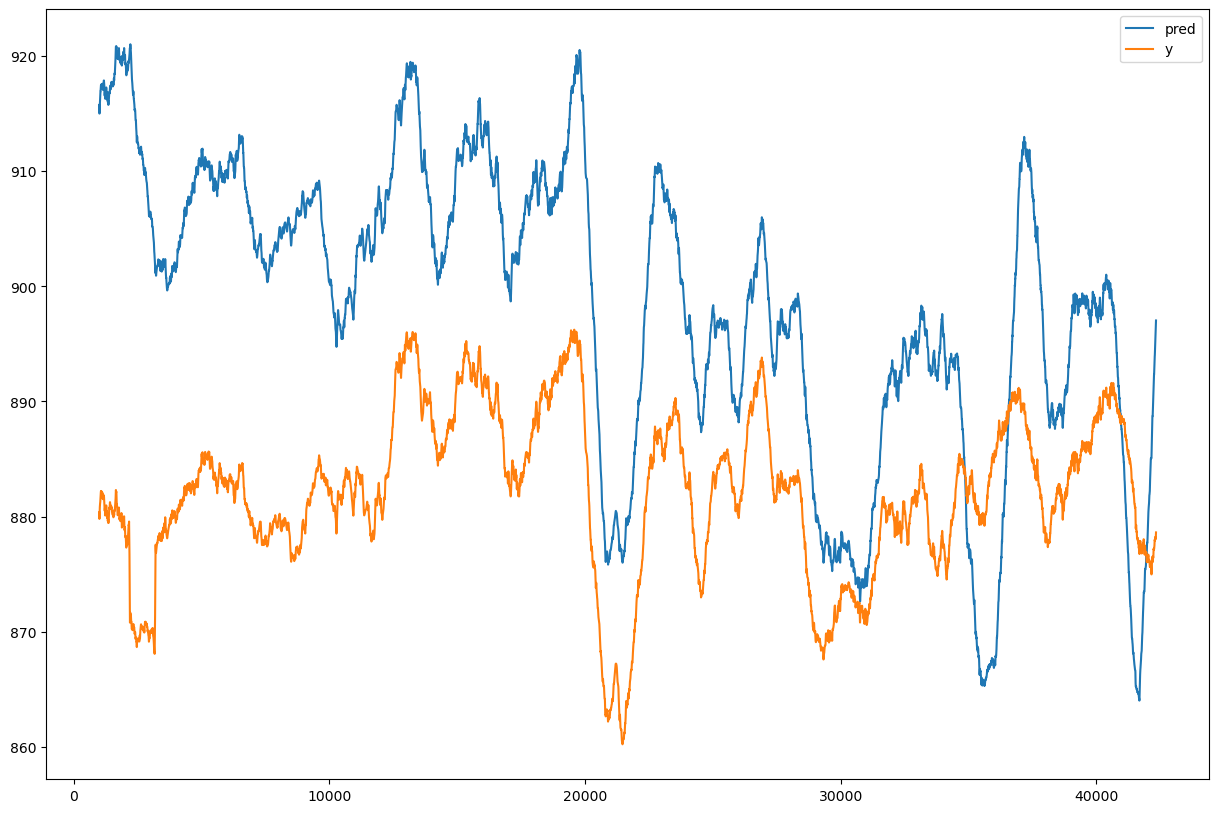

In [37]:
b.visualize()

In [19]:
b.model_LGB()

[I 2023-02-21 09:23:58,851] A new study created in memory with name: no-name-3c575c9d-363c-43a5-ad97-8adb3afb03e1
C:\Users\saint\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-02-21 09:23:59,099] Trial 0 finished with value: 927.9426742492068 and parameters: {'max_depth': 3}. Best is trial 0 with value: 927.9426742492068.
C:\Users\saint\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-02-21 09:23:59,397] Trial 1 finished with valu

(927.9426742492068, {'max_depth': 3})

In [21]:
b.train_predict()

array([920.77180956, 924.59904126, 949.90527721, ..., 921.61828396,
       914.00847159, 900.19518488])

In [25]:
print(b)

이 클래스 객체는 모델들의 성능을 비교해 최적의 모델을 찾아낸 후, 데이터를 재학습한 뒤, 시각화를 포함한 결과를 출력합니다


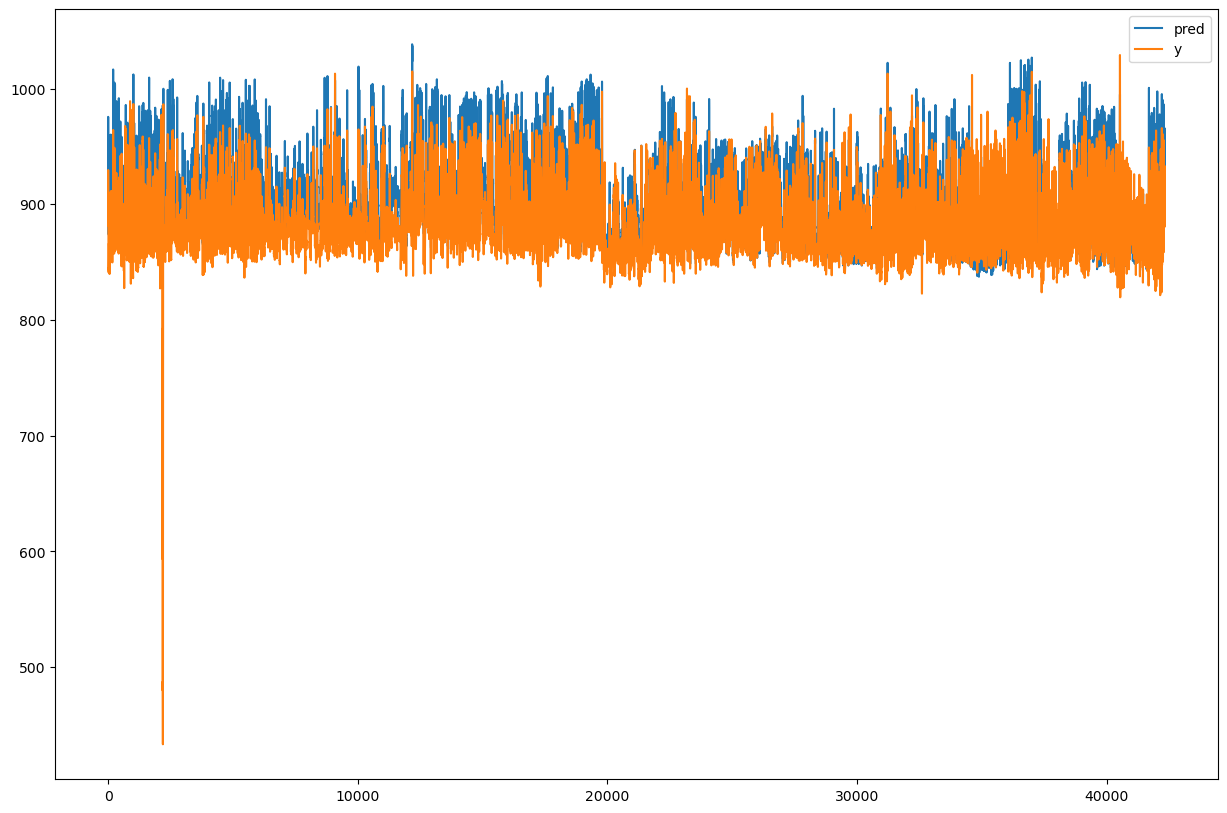

In [16]:
b.visualize()

In [15]:
test_y

array([881.83108521, 890.65689087, 899.46438599, ..., 902.66879272,
       895.41772461, 885.8777771 ])